In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import statsmodels.formula.api as smf
import random

In [4]:
sleep = pd.read_csv("/Users/herrakaava/Documents/school/sekamallit/week_2/sleep_study.csv", index_col=0)

In [5]:
sleep.head()

,Reaction,Days,Subject
1,249.5600,0,308
2,258.7047,1,308
3,250.8006,2,308
4,321.4398,3,308
5,356.8519,4,308


In [6]:
sleep.shape

(180, 3)

- 18 subjects, 10 measurements from each subject.

In [7]:
sleep.info()

<class 'pandas.core.frame.DataFrame'>
Index: 180 entries, 1 to 180
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Reaction  180 non-null    float64
 1   Days      180 non-null    int64  
 2   Subject   180 non-null    int64  
dtypes: float64(1), int64(2)
memory usage: 5.6 KB


In [21]:
sleep.loc[:, "Days"].value_counts()

Days
0    18
1    18
2    18
3    18
4    18
5    18
6    18
7    18
8    18
9    18
Name: count, dtype: int64

In [22]:
sleep.loc[:, "Subject"].value_counts()

Subject
308    10
309    10
371    10
370    10
369    10
352    10
351    10
350    10
349    10
337    10
335    10
334    10
333    10
332    10
331    10
330    10
310    10
372    10
Name: count, dtype: int64

In [39]:
sleep.groupby("Days")["Subject"].value_counts()

Days  Subject
0     308        1
      309        1
      310        1
      330        1
      331        1
                ..
9     352        1
      369        1
      370        1
      371        1
      372        1
Name: count, Length: 180, dtype: int64

In [41]:
c = sleep.groupby("Days")["Subject"].value_counts().reset_index(name="Count")

In [42]:
c

,Days,Subject,Count
0,0,308,1
1,0,309,1
2,0,310,1
3,0,330,1
4,0,331,1
...,...,...,...
175,9,352,1
176,9,369,1
177,9,370,1
178,9,371,1


In [45]:
(c["Count"].values == 1).all()

True

- All 18 subjects had 1 measurement per day for 10 days.

<h3>Visualize</h3>

In [148]:
def f(data):
    unique_subjects = data["Subject"].unique()    # Unique subjects
    fig, ax = plt.subplots(figsize=(12,6), 
                           dpi=100, 
                           nrows=2, 
                           ncols=9,
                           sharex=True,
                           sharey=True)
    ax = ax.ravel()
    for i in range(unique_subjects.size):
        # Filter data to contain only specific subject
        subject_i = data[data["Subject"] == unique_subjects[i]]
        
        # Best-fit line for the ith subject
        fit_i = smf.ols("Reaction ~ Days", data=subject_i).fit()
        params = fit_i.params.values
        
        ax[i].plot(subject_i["Days"].values, 
                   subject_i["Reaction"].values, 
                   marker="o", 
                   markerfacecolor="none",
                   linestyle="none",
                   color="black")
        ax[i].set_title(f"{unique_subjects[i]}")
        ax[i].grid(True)
        ax[i].set_xticks([0, 2, 4, 6, 8])
        
        # Plot best fit line of the ith subject
        ax[i].plot(subject_i["Days"].values, 
                   params[0] + subject_i["Days"].values * params[1])
        
    plt.tight_layout()

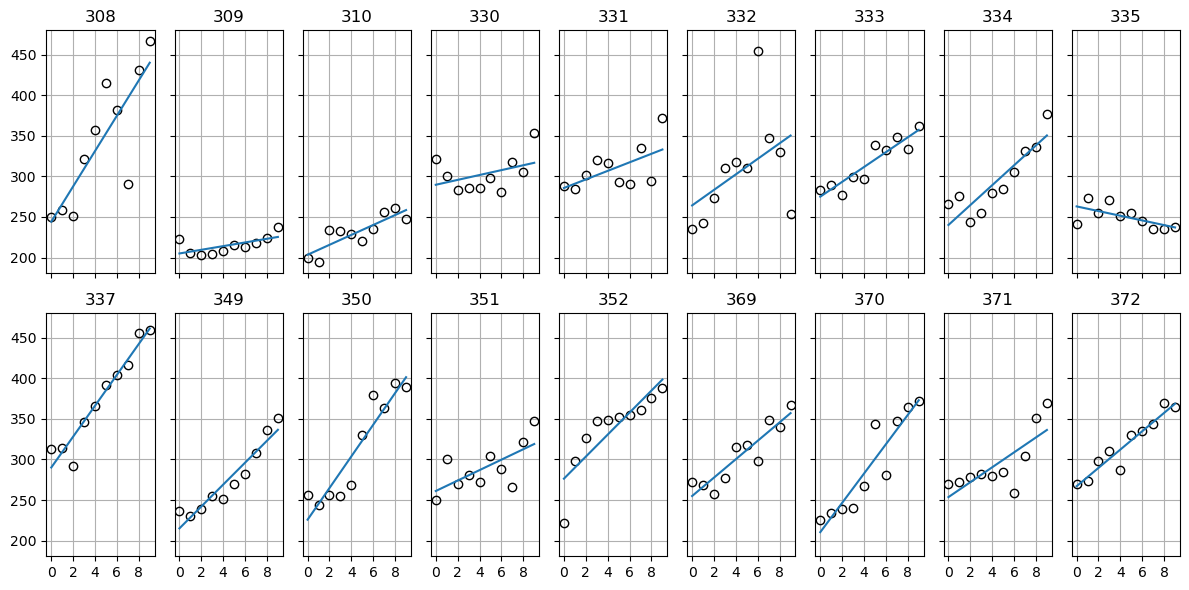

In [149]:
f(sleep)

- It seems that there is differences between the subjects in both the general level of reaction time (baseline, before the experiment started), and in the development of the slope of the best-fit line (some people are influenced by the sleep derivation more than others).

Let's define a random slope model:

$$ \large y_{ij} = (\beta_0 \, + \, \boldsymbol{b}_{i0}) \, + \, (\beta_1 \, + \, \boldsymbol{b}_{i1})j \, + \, \epsilon_{ij}, $$

where $\, i \in \{1,...,18\} \,$ indexes the individuals, and $\, j \in \{0,...,9\} \,$ corresponds to the measurement day.

Fixed effects: $\, \beta_0, \beta_1 \,$

Random effects: 

$$ \large \boldsymbol{b}_i = \begin{pmatrix}
b_{i0} \\
b_{i1}
\end{pmatrix} \sim N_2 \left(\boldsymbol{0}, \begin{pmatrix}
\tau^2_0 & \tau_{01} \\
\tau_{01} & \tau^2_{1}
\end{pmatrix}
 \right)
 $$
 
The error terms $\, \epsilon_{ij} \sim N(0, \sigma^2). \,$ \
The random variables $\, \boldsymbol{b}_i \,$ and $\, \epsilon_{ij} \,$ are assumed to be independent of each other.

$\large\beta_0$:

- $\beta_0 \,$ is the fixed intercept for the entire study population.
- It represents the average intercept across all individuals in the study (study population intercept).

$\large\beta_1$:

- $\beta_1 \,$ represents the fixed effect of the time (measurement day) variable **j** on the response variable (reaction time).
- $\beta_1 \,$ is the average rate rate of change in the reaction time per one unit increase in j (i.e., per measurement day) across all individuals.
- Fixed slope of the time effect.
- If $\, \beta_1 \,$ is positively large, the best-fit lines in the graph above would be more vertically placed (i.e., the reaction times would get slower much more faster after each day).

$\large\tau^2_0$:

- $\tau^2_0 \,$ represents the **variance** of the random intercepts $\, \boldsymbol{b}_{i0}. \,$
- It describes the variability of the individual intercepts around the fixed intercept $\, \beta_0. \,$
- If $\tau^2_0 \,$ is large, then the intercepts in the graph above would spread further apart, indicating more variability in the individual intercepts. 

$\large\tau^2_1$:

- $\tau^2_1 \,$ represents the **variance** of the random slopes $\, \boldsymbol{b}_{i1}. \,$  
- It describes the individual slopes around the (fixed) study population slope $\, \beta_1. \,$
- If $\tau^2_1 \,$ is close to zero, then the steepness (rate of change) of the best-fit lines would be consistent between the subjects.

$\large\frac{\tau_{01}}{\tau_0 \tau_1}$:

- $\tau_{01} \,$ is the covariance between the random intercepts and random slopes.
- $\tau_0 \,$ is the standard deviation of the random intercepts.
- $\tau_1 \,$ is the standard devaition of the random slopes \
$\, \boldsymbol{\rightarrow} \, \large\frac{\tau_{01}}{\tau_0 \tau_1} \,$ is the correlation between the random intercepts $\, \boldsymbol{b}_{i0} \,$ and the random slopes $\, \boldsymbol{b}_{i1}. \,$
- If the correlation is close to 1, it means that individuals whose baseline reaction time is higher, tend to also experience faster rate of increasing in the reaction time (i.e., those who had bad reaction times in the first place, tend to experience faster decrease in performance of reaction time compared to individuals who had better reaction time before the sleep deprivation).

$\large\sigma^2$:

- Variance of the residuals $\, \epsilon_{ij}, \,$ which capture the variability **within** subjects (deviations of the observed data points $\, y_{ij} \,$ from the values predicted by the model for each individual).
- It accounts for the random noise (errors) that is not explained neither by the fixed effects ($\, \beta_0, \beta_1 \,$) and the random effects ($\, \boldsymbol{b}_0, \boldsymbol{b}_1$).
- $\sigma \,$ provides a measure of how much the observed data points $\, y_{ij} \,$ deviate from the predicted values for each individual on average.
- A small value of $\, \sigma \,$ indicates that the model provides a good fit to the data.

<h3>Task 4</h3>

In [22]:
def sample_subjects(arr):
    """
    Args:
    arr -- a list containing the number of observations per subject.
    """
    # df to store the data
    my_data = pd.DataFrame()
    # Create the observations for one subject at a time
    for i in range(len(arr)):
        n_i = arr[i]
        rand_eff = np.random.normal(loc=0, scale=1, size=1)
        y = rand_eff * np.repeat(a=1, repeats=n_i) + np.random.normal(loc=0, scale=1, size=n_i)
        temp = pd.DataFrame({
            "response": np.round(y, 2),
            "subject": np.repeat(i+1, n_i)
        })
        my_data = pd.concat([my_data, temp], axis=0, ignore_index=True)
    my_data["subject"] = my_data["subject"].astype("category")
    my_data.index += 1
    return my_data

**Equal number of observations per subject**

In [54]:
df_n_equal = sample_subjects([3, 3, 3, 3])

In [55]:
df_n_equal

,response,subject
1,1.19,1
2,-0.07,1
3,-0.08,1
4,1.12,2
5,0.18,2
6,0.77,2
7,-0.89,3
8,-0.24,3
9,0.53,3
10,-0.14,4


In [56]:
def random_intercept_model(data):
    model = smf.mixedlm("response ~ 1",
                        groups=data["subject"],
                        data=data).fit(reml=False)
    print(model.summary())

In [57]:
def REML_model(data):
    model = smf.mixedlm("response ~ 1",
                        groups=data["subject"],
                        data=data).fit(reml=True)
    print(model.summary())

In [58]:
random_intercept_model(df_n_equal)

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: response
No. Observations: 12      Method:             ML      
No. Groups:       4       Scale:              0.3942  
Min. group size:  3       Log-Likelihood:     -13.1735
Max. group size:  3       Converged:          Yes     
Mean group size:  3.0                                 
------------------------------------------------------
              Coef. Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------
Intercept     0.013    0.279 0.048 0.962 -0.534  0.561
Group Var     0.181    0.431                          



In [59]:
REML_model(df_n_equal)

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: response
No. Observations: 12      Method:             REML    
No. Groups:       4       Scale:              0.3942  
Min. group size:  3       Log-Likelihood:     -13.4611
Max. group size:  3       Converged:          Yes     
Mean group size:  3.0                                 
------------------------------------------------------
              Coef. Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------
Intercept     0.013    0.323 0.041 0.967 -0.619  0.646
Group Var     0.285    0.635                          



**Different number of observations per subject**

In [60]:
df_n_diff = sample_subjects([3, 6, 2, 4])

In [61]:
df_n_diff

,response,subject
1,0.64,1
2,0.62,1
3,0.24,1
4,0.38,2
5,0.49,2
6,1.77,2
7,-0.25,2
8,0.95,2
9,0.11,2
10,0.74,3


In [63]:
random_intercept_model(df_n_diff)

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: response
No. Observations: 15      Method:             ML      
No. Groups:       4       Scale:              0.8954  
Min. group size:  2       Log-Likelihood:     -20.7253
Max. group size:  6       Converged:          Yes     
Mean group size:  3.8                                 
------------------------------------------------------
              Coef. Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------
Intercept     0.152    0.269 0.568 0.570 -0.374  0.679
Group Var     0.035    0.209                          



In [62]:
REML_model(df_n_diff)

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: response
No. Observations: 15      Method:             REML    
No. Groups:       4       Scale:              0.9058  
Min. group size:  2       Log-Likelihood:     -21.0723
Max. group size:  6       Converged:          Yes     
Mean group size:  3.8                                 
------------------------------------------------------
              Coef. Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------
Intercept     0.138    0.306 0.452 0.651 -0.461  0.737
Group Var     0.114    0.310                          



- $\, \boldsymbol{\tau}^2 \,$ (*Group Var* in the summary output) refers to the variance of the random effects (i.e., the variance between the groups (subjects in this case))

**Increase the number of observations within each group**

In [100]:
random_intercept_model(sample_subjects([1000000, 1000000, 1000000, 1000000]))

            Mixed Linear Model Regression Results
Model:            MixedLM   Dependent Variable: response     
No. Observations: 4000000   Method:             ML           
No. Groups:       4         Scale:              0.9996       
Min. group size:  1000000   Log-Likelihood:     -5674977.2533
Max. group size:  1000000   Converged:          Yes          
Mean group size:  1000000.0                                  
--------------------------------------------------------------
               Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
--------------------------------------------------------------
Intercept      -0.027     0.500  -0.054  0.957  -1.007   0.953
Group Var       1.000     1.130                               



In [101]:
REML_model(sample_subjects([1000000, 1000000, 1000000, 1000000]))

            Mixed Linear Model Regression Results
Model:            MixedLM   Dependent Variable: response     
No. Observations: 4000000   Method:             REML         
No. Groups:       4         Scale:              1.0001       
Min. group size:  1000000   Log-Likelihood:     -5675947.5890
Max. group size:  1000000   Converged:          Yes          
Mean group size:  1000000.0                                  
--------------------------------------------------------------
               Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
--------------------------------------------------------------
Intercept      -0.655     0.500  -1.310  0.190  -1.635   0.325
Group Var       1.000                                         



/Users/herrakaava/anaconda3/envs/sekamallit/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
